Hi. In this notebook, we are going to be training a Variational Autoencoder (VAE) on the Fashion-MNIST dataset using PyTorch. Let's go!

### Basic imports

In [1]:
## Standard libraries
import os
import numpy as np
import time
from random import sample, randint

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Progress bar
from tqdm.notebook import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
print("Using torch", torch.__version__)

Using torch 2.1.0+cu118


We define a function to set a seed on all libraries we might interact with in this notebook (`numpy` and `torch`). This allows us to make our training reproducible.

In [3]:
DATASET_PATH = "/data"  # Path where datasets are downloaded

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


We define some helper functions for plotting the images:

In [4]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

# Display images, n=max number of images to show
def display_images(in_raw, out_raw, n=1):
    out_raw = out_raw[:n]
    if in_raw is not None:
        in_raw = in_raw[:n]
        in_pic = to_img(in_raw.cpu().data).view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(in_pic[i])
            plt.axis('off')
    out_pic = to_img(out_raw.cpu().data).view(-1, 28, 28)
    plt.figure(figsize=(18, 6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(out_pic[i])
        plt.axis('off')
    plt.show()

### Step 1: Downloading Fashion-MNIST

In [5]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image =>
# first make them a tensor, then normalize them in the range -1 to 1
resize = (28, 28)
transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = FashionMNIST(root=DATASET_PATH, train=True,
                         transform=transform, download=True)

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False,
                        transform=transform, download=True)

In [6]:
# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True,
                               drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False,
                              drop_last=False)

## Step 2: Implementation

### Defining the model

In [7]:
class VAE(nn.Module):
    def __init__(self, d=50):
        super().__init__()
        self.d = d  # Dimension of latent space

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2) # Mean and variance are both d-dim vectors
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Tanh()
        )

    def sampler(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.sampler(mu, logvar)
        return self.decoder(z), mu, logvar

    def generate(self, N=10):
        z = torch.randn((N, self.d)).to(device)
        gen_img = self.decoder(z)
        return gen_img

### Defining the loss function

In [8]:
def loss_function(x_hat, x, mu, logvar, beta=1):
    recon_loss = F.mse_loss(x_hat, x.view(-1, 784), reduction='sum')
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return recon_loss + beta * KLD

### Train the VAE

====> Test set loss: 534.7603


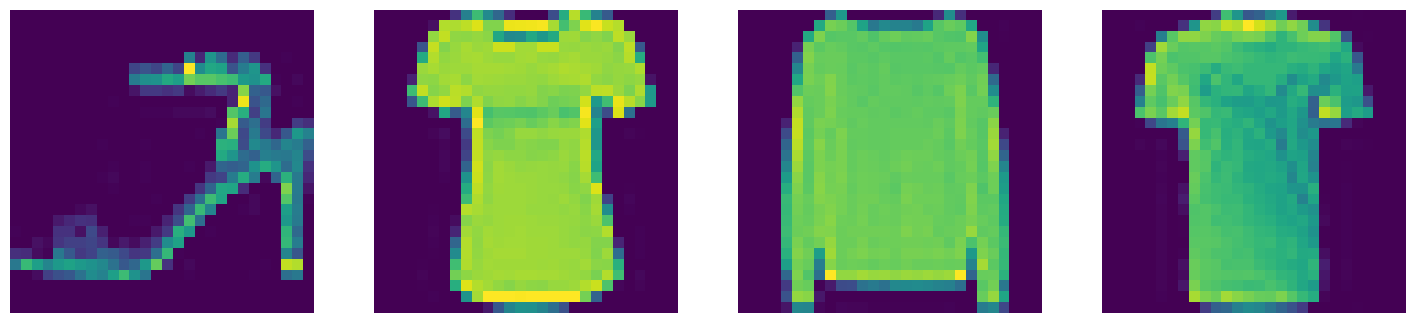

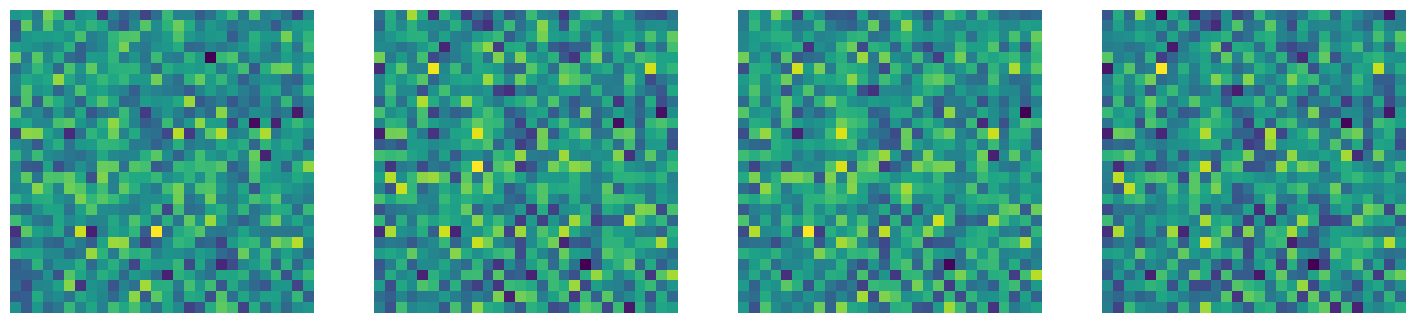

====> Epoch: 1 Average loss: 92.3742
====> Test set loss: 68.1020
====> Epoch: 2 Average loss: 73.0323
====> Test set loss: 64.3152
====> Epoch: 3 Average loss: 69.8324
====> Test set loss: 62.0080
====> Epoch: 4 Average loss: 68.1585
====> Test set loss: 61.5016
====> Epoch: 5 Average loss: 67.0158
====> Test set loss: 60.8903
====> Epoch: 6 Average loss: 66.2648
====> Test set loss: 58.8342
====> Epoch: 7 Average loss: 65.6491
====> Test set loss: 58.1631
====> Epoch: 8 Average loss: 65.0634
====> Test set loss: 58.2687
====> Epoch: 9 Average loss: 64.6279
====> Test set loss: 57.9573
====> Epoch: 10 Average loss: 64.2018
====> Test set loss: 57.3981


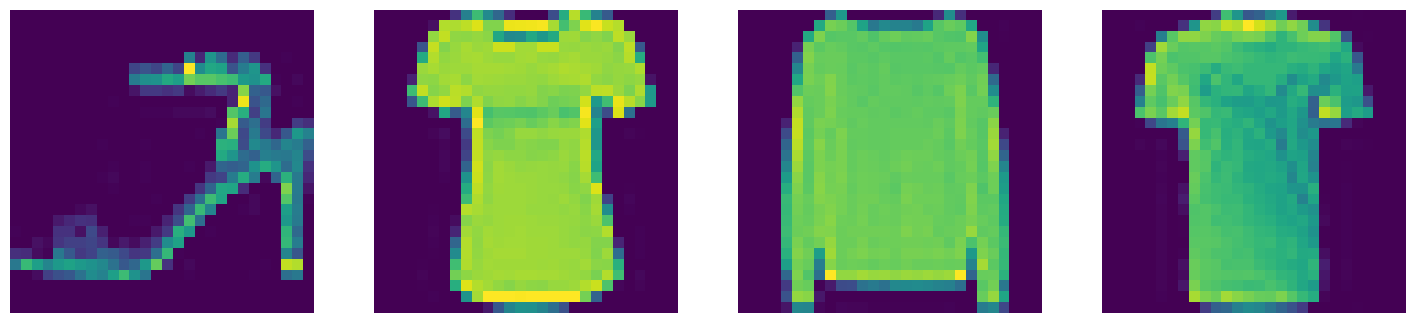

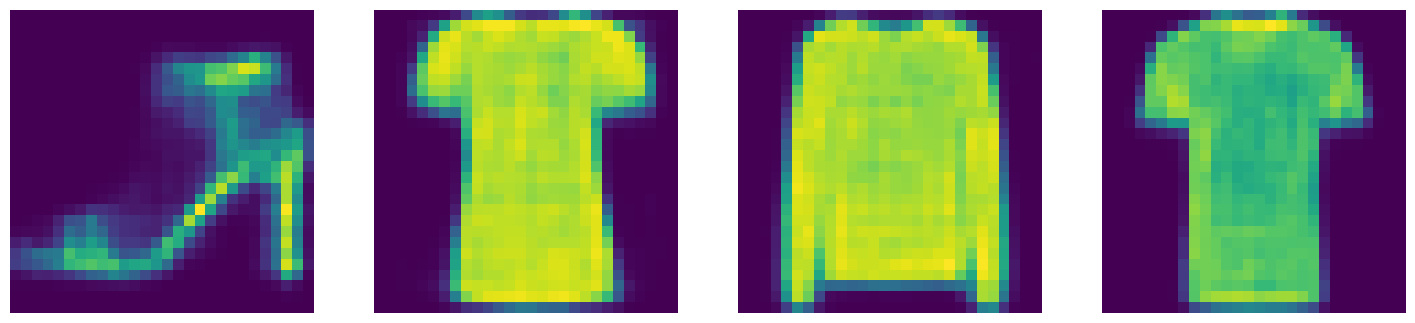

====> Epoch: 11 Average loss: 63.9531
====> Test set loss: 57.6325
====> Epoch: 12 Average loss: 63.6862
====> Test set loss: 57.8549
====> Epoch: 13 Average loss: 63.4172
====> Test set loss: 56.6862
====> Epoch: 14 Average loss: 63.1917
====> Test set loss: 56.7961
====> Epoch: 15 Average loss: 63.0127
====> Test set loss: 57.0030
====> Epoch: 16 Average loss: 62.8683
====> Test set loss: 56.8393
====> Epoch: 17 Average loss: 62.7277
====> Test set loss: 56.8649
====> Epoch: 18 Average loss: 62.5276
====> Test set loss: 55.5182
====> Epoch: 19 Average loss: 62.4373
====> Test set loss: 56.2289
====> Epoch: 20 Average loss: 62.3266
====> Test set loss: 56.8384


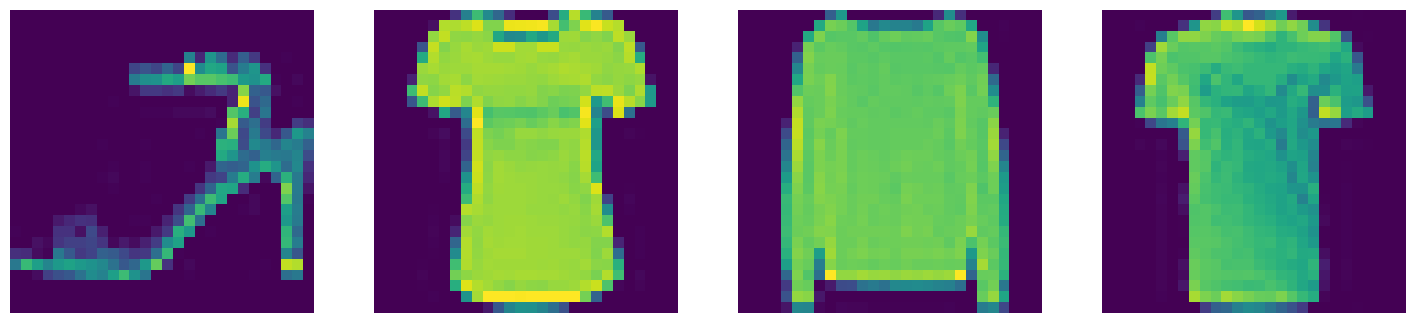

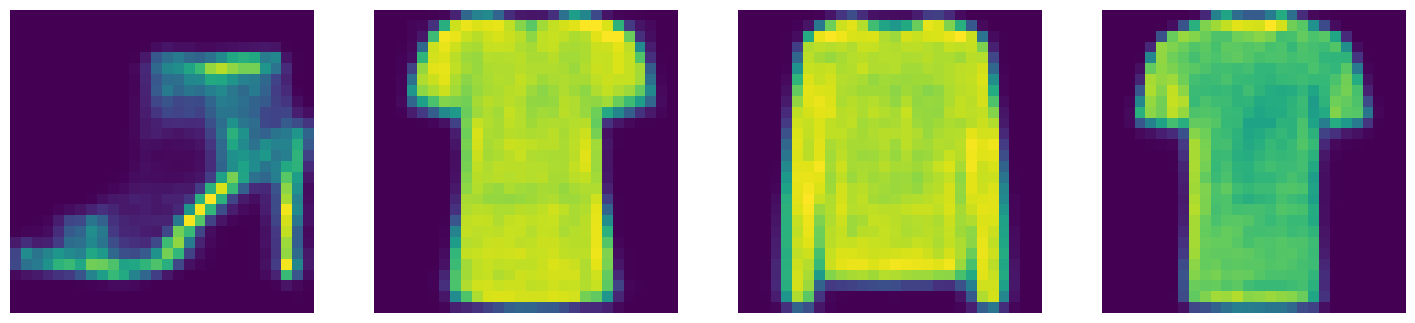

====> Epoch: 21 Average loss: 62.1973
====> Test set loss: 55.9728
====> Epoch: 22 Average loss: 62.0910
====> Test set loss: 56.2368
====> Epoch: 23 Average loss: 62.0026
====> Test set loss: 56.3122
====> Epoch: 24 Average loss: 61.9368
====> Test set loss: 55.3324
====> Epoch: 25 Average loss: 61.8249
====> Test set loss: 56.3468


In [9]:
latent_dim = 20
model = VAE(latent_dim).to(device)

# Setting the optimiser
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 25
codes = dict(mu=list(), log_var=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)

            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # Forward pass
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # Store the values
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())

    codes['mu'].append(torch.cat(means))
    codes['log_var'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)

    print(f'====> Test set loss: {test_loss:.4f}')
    if epoch % 10 == 0:
      display_images(x, x_hat, 4)

## Generate images from the trained model

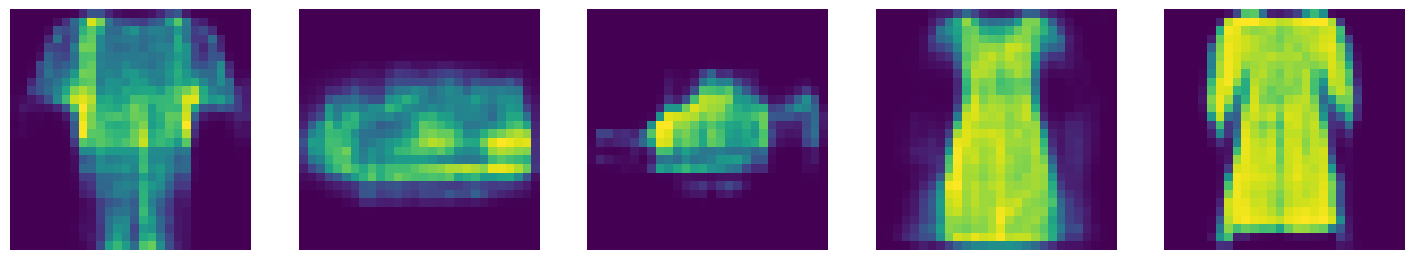

In [10]:
N=5
display_images(None, model.generate(N), N)

## Visualize transitions between images

In [14]:
import random
sample_ = random.sample([*range(256)], 10)
print(sample_)

[124, 63, 213, 173, 102, 46, 34, 120, 206, 160]




Example 1


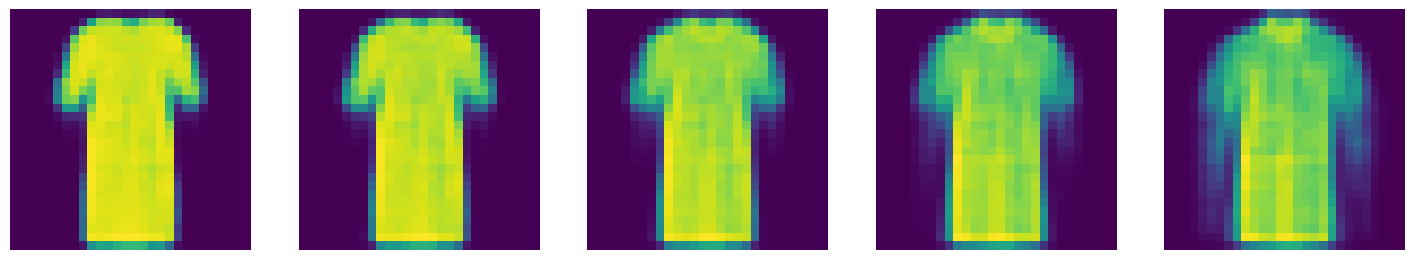

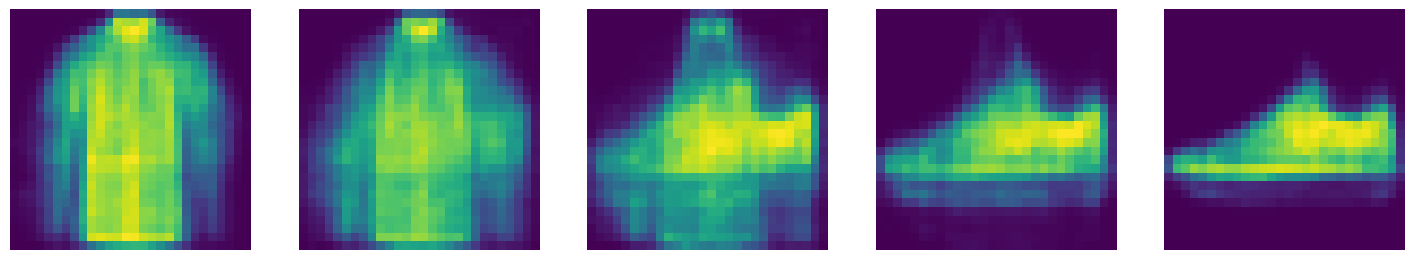



Example 2


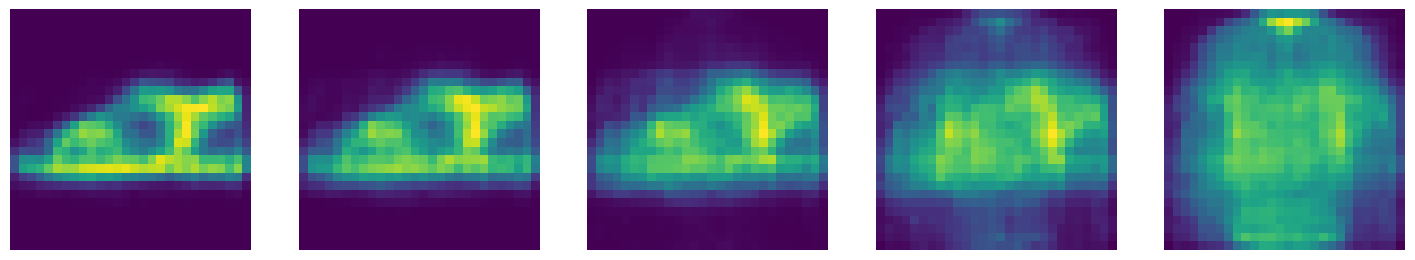

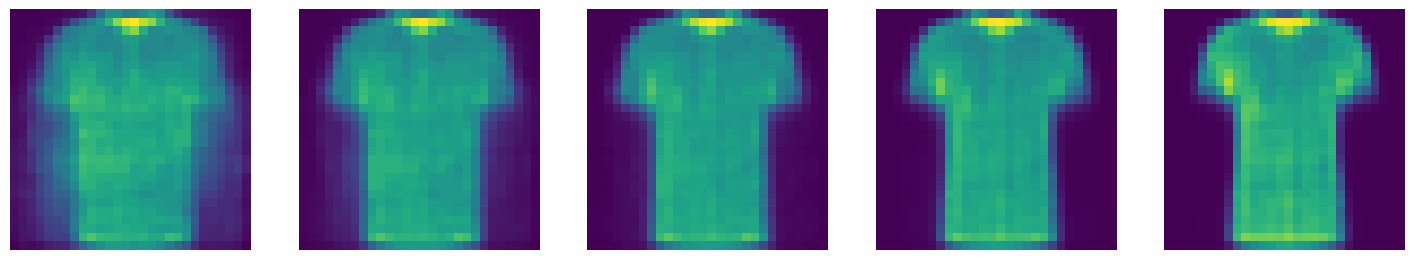



Example 3


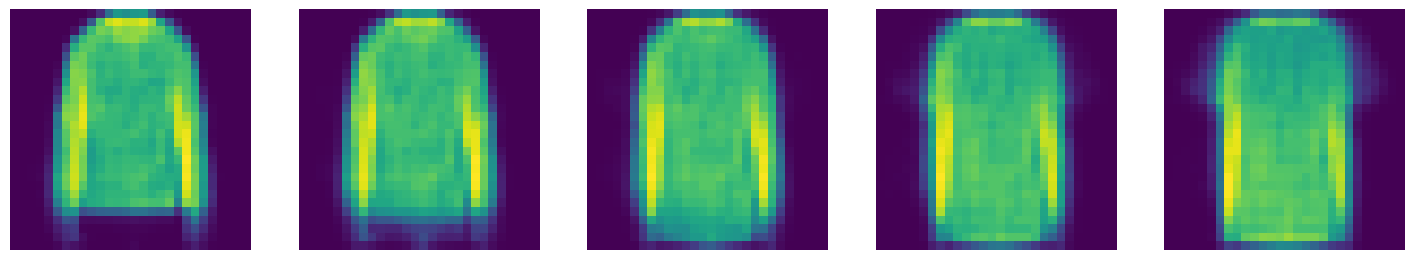

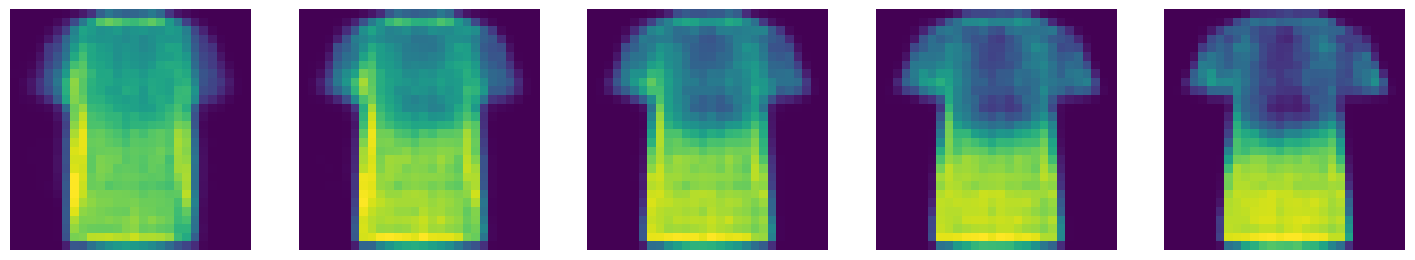



Example 4


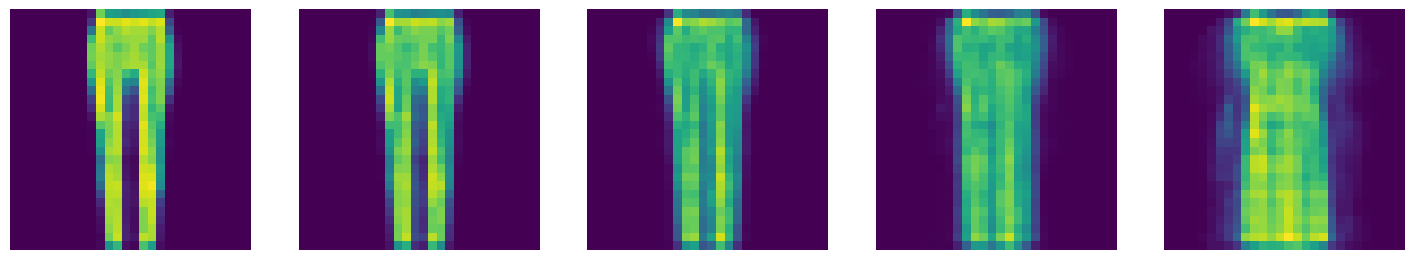

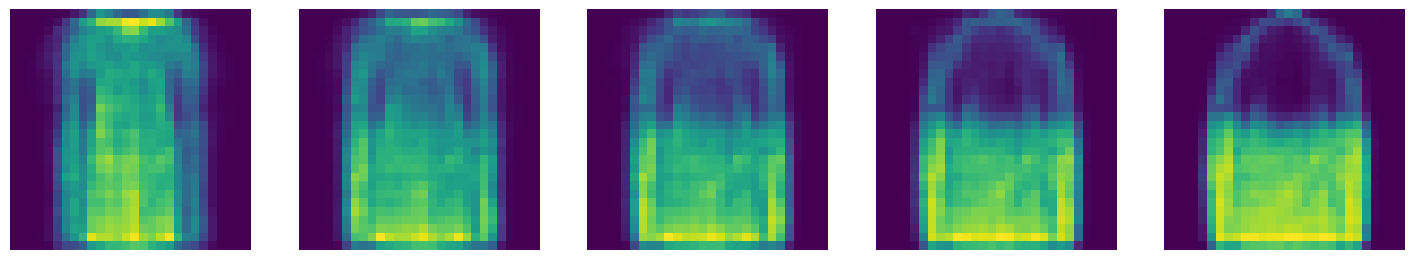



Example 5


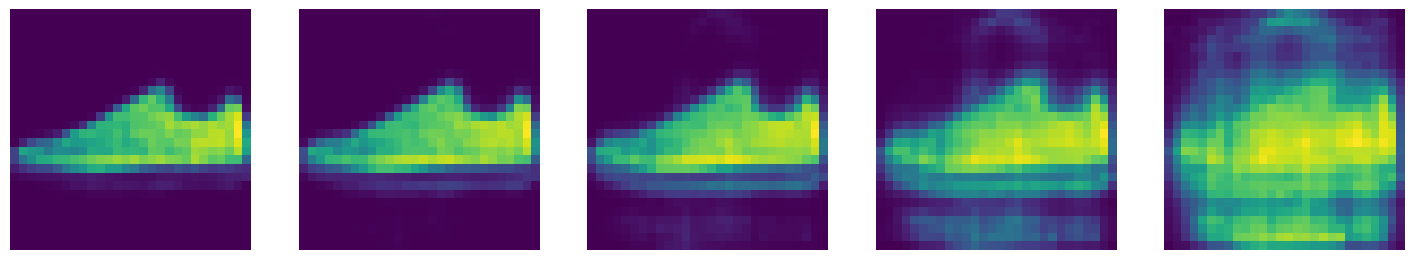

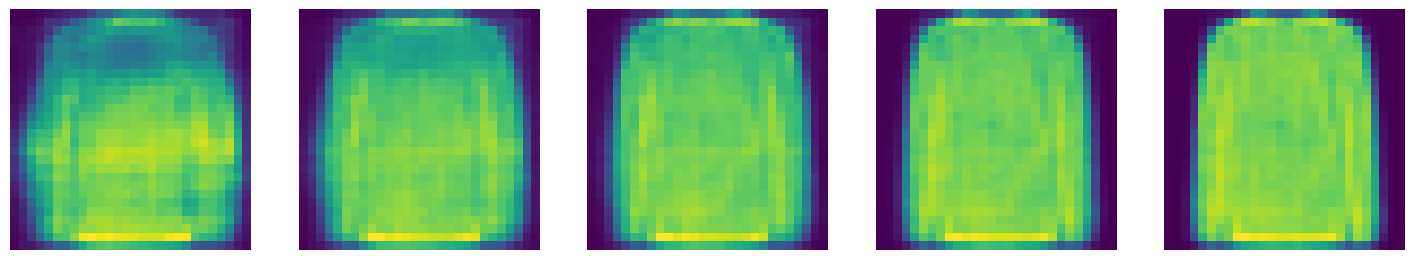

In [15]:
for j in range(5):
    print(f'\n\nExample {j+1}')

    x, _ = next(iter(test_loader))
    x = x.to(device)
    x_hat, mu, logvar = model(x)

    # Perform an interpolation between input A and B, in N steps
    A, B, N = sample_[j], sample_[-j-1], 10
    code = torch.Tensor(N, latent_dim).to(device)
    sample = torch.Tensor(N, 28, 28).to(device)
    for i in range(N):
        code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    img_set = model.decoder(code)
    for i in range(N//5):
        display_images(None, img_set[i*5:5*(i+1)], 5)